In [1]:
import audiolabel
import parselmouth as ps  # This provides Praat functionality within python
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA  # This provides linear algebra helper functions for calculating distances, which we use in the function apPal

pd.options.mode.chained_assignment = None  # default='warn'; this line suppresses some warnings from pandas

# Unit 3: XRMB

The X-Ray Microbeam Database is a set of articulatory and acoustic recordings collected in 1989-1991 at the University of Wisconsin

We have two types of raw data available -- audio recordings of a variety of speech tasks taken on by speakers in the study (**audio**) and the positions of pellets glued to different parts of speakers' jaw, tongue, lips, and face during these speech tasks (**xrmb**). We also have access to annotations in the form of TextGrids generated using forced alignment by Keith Johnson for a previous course. 
These data have the following file structure and naming conventions:
- data
    - subject -- JW followed by a number
        - PAL.DAT -- the palate trace for the subject
        - PHA.DAT -- the approximated pharyngeal trace for the subject
        - taN.wav -- audio recordings without accompanying xrmb data
        - tpN.wav -- audio recordings *with* accompanying xrmb data
        - tpN.txy -- accompanying xrmb data
- annotation
    - subject -- same as above
        - tpN.TextGrid -- accompanying forced aligned annotations; these have the typical forced aligned structure of words on tier 1 and phones on tier 2

In [2]:
annotations = os.path.abspath('./annotation')
datadir = os.path.abspath('./data')

## Getting to know the xrmb data

Let's check out some data and see what we're working with! First we can establish a list of the subjects, and then pick one of them and look at their files.

In [3]:
subjects = [s for s in os.listdir(datadir) if os.path.isdir(os.path.join(datadir,s))]
len(subjects) # how many subjects are there?

48

## Manipulating the xrmb data

There are many different kinds of questions we might try to answer with these data. The specific question we are trying to replicate is (in two parts)
1. Are tongue tip constrictions in post-vocalic /l/s weaker preceding bilabial and velar stops compared to alveolar stops?
2. Is this difference between magnitude of constriction affected by lexical frequency whereby more frequent words show weaker constrictions than stronger words?

One manipulation we'll need is to measure the distance between the tongue tip (T1) and the palate trace, aka "tongue tip aperture". We'll find all of the distances from the T1 point to every point on the palate and give the minimum of those points, as well as the spot on the palate resulting in that minimum.
(Another, almost certaily faster, way to approach this same question is to use the y-cooridinate of T1 as a proxy for tongue height.)

The following is a function that determines the distance between the palate and any tongue point using the method above. 
- It takes as input the **row** of data from the xrmb dataframe, the dataframe containing the palate trace **paldf**, and the number of the point to measure distance from **TN**.
- It returns the distance between that point and the palate trace

In [4]:
def apPal(row, paldf, TN):
    
    xval=row[''.join(['T',str(TN),'x'])]
    yval=row[''.join(['T',str(TN),'y'])]
    paltemp = paldf.copy()
    paltemp['ap']=paltemp.apply(lambda x: LA.norm(np.array([xval,yval])-np.array([x.x, x.y])), axis=1)
    
    return paltemp.iloc[paltemp['ap'].argmin()]

In [5]:
names=[
    'time', 'ULx', 'ULy', 'LLx', 'LLy', 'T1x', 'T1y', 'T2x', 'T2y',
    'T3x', 'T3y', 'T4x', 'T4y', 'MIx', 'MIy', 'MMx', 'MMy'
]

**This is the cell where you'll make most changes for gathering data.**

In [6]:
alldf = pd.DataFrame()

# for sub in subjects[0:1]: ## you can uncomment this if you want to test just a single subject before running it on everyone
for sub in subjects:
    
    subdata = os.path.join(datadir,sub)
    subannotations = os.path.join(annotations,sub)
    xfiles = [f for f in os.listdir(subdata) if f[-4:]=='.txy']  # These are the xray files
    tgfiles = [f for f in os.listdir(subannotations) if f[-9:]=='.TextGrid']  # We don't really need to check if they are TextGrids but it's still nice to

    palfile = os.path.join(subdata, 'PAL.DAT')
    phafile = os.path.join(subdata, 'PHA.DAT')
    paldf = pd.read_table(palfile, sep='\s+', header=None, names=['x', 'y'])/1000
    phadf = pd.read_table(phafile, sep='\s+', header=None, names=['x', 'y'])/1000
    
    for f in xfiles:
        prefix = f[:-4]
        try:
            xdata = pd.read_table(os.path.join(subdata,prefix+'.txy'),names=names)

            xdata = xdata.replace(1000000,np.nan)
            xdata = xdata/1000
            xdata.time = xdata.time/1000

            if not os.path.isfile(os.path.join(annotations,sub,prefix+'.TextGrid')):
                print(' '.join(["No annotation found for",sub,prefix]))
                continue

            tg = audiolabel.LabelManager(from_file=os.path.join(annotations,sub,prefix+'.TextGrid'),from_type='praat')
            [phonedf, worddf] = tg.as_df()

            phonedf=phonedf.rename(columns={"text":"phone"})
            phonedf['phoneprev'] = phonedf.phone.shift()
            phonedf['phonenext'] = phonedf.phone.shift(-1)
            worddf=worddf.rename(columns={"text":"word"})
            timesdf = pd.merge_asof(phonedf, worddf, on='t1')
            timesdf=timesdf.rename(columns={"t2_x":"t2"})
            timesdf=timesdf.rename(columns={"center_x":"center"})
            timesdf=timesdf[['t1','t2','center','phone','phoneprev','phonenext','word']]
            timesdf['wordonset'] = ~(timesdf.word==timesdf.word.shift())
            timesdf['wordend'] = ~(timesdf.word==timesdf.word.shift(-1))
            timesdf['vowel'] = timesdf.phone.apply(lambda x: len(x)==3)
            timesdf['stress'] = timesdf.phone.apply(lambda x: x[-1] if len(x)>0 else '')
            timesdf = timesdf.replace(np.nan,'')

            # xdata = pd.merge_asof(xdata, timesdf, left_on='time', right_on='t1')
            xdata = pd.merge_asof(timesdf, xdata, left_on='center', right_on='time')  ## this will get just the xrmb data at the midpoint of each phone

            # edit the next line for the segment(s) you're interested in
            segdf = xdata[xdata.vowel==True]
            segdf['file']=prefix
            segdf['subject']=sub

            if len(segdf)>0:  # edit these two lines for the points you are interested in
                alldf = pd.concat([alldf,segdf])
        except:
            print(' '.join(["Error for",sub,prefix]))
    
print('Done!')

No annotation found for JW21 tp117
No annotation found for JW21 tp118_2
No annotation found for JW21 tp106
No annotation found for JW21 tp118
No annotation found for JW19 tp117
No annotation found for JW19 tp106
No annotation found for JW19 tp118
No annotation found for JW502 tp106_3
No annotation found for JW502 tp106_2
No annotation found for JW502 tp116
No annotation found for JW502 tp117
No annotation found for JW502 tp115
No annotation found for JW502 tp114
No annotation found for JW502 tp110
No annotation found for JW502 tp111
No annotation found for JW502 tp107
No annotation found for JW502 tp113
No annotation found for JW502 tp112
No annotation found for JW502 tp106
No annotation found for JW502 tp108
No annotation found for JW502 tp109
No annotation found for JW502 tp118
No annotation found for JW502 tp117_2
No annotation found for JW26 tp116
No annotation found for JW26 tp117
No annotation found for JW26 tp115
No annotation found for JW26 tp114
No annotation found for JW26 tp

This dataset looks a bit different from thes ones we used before.

In [7]:
alldf.head()

,t1,t2,center,phone,phoneprev,phonenext,word,wordonset,wordend,vowel,...,T3x,T3y,T4x,T4y,MIx,MIy,MMx,MMy,file,subject
2,1.149887,1.209751,1.179819,EH1,W,N,WHEN,False,False,True,...,-41.848,9.468,-53.011,4.123,-5.018,-9.308,-46.040,-7.177,tp029,JW21
4,1.259637,1.509070,1.384354,AO1,N,L,ALL,True,False,True,...,-44.835,7.001,-60.768,7.890,-4.288,-17.083,-44.974,-12.846,tp029,JW21
6,1.539002,1.658730,1.598866,EH1,L,L,ELSE,True,False,True,...,-37.528,9.365,-52.774,8.219,-5.861,-14.743,-46.428,-11.020,tp029,JW21
10,2.031795,2.187528,2.109662,EY1,F,L,FAILS,False,False,True,...,-33.315,11.986,-46.779,8.145,-4.688,-12.919,-45.166,-10.130,tp029,JW21
15,2.915873,3.045578,2.980726,UW1,Y,S,USE,False,False,True,...,-37.267,13.433,-50.724,8.504,-2.048,-4.914,-43.646,-4.789,tp029,JW21


Squish all vowels of the same quality together (regardless of stress) and find their mean values.

In [30]:
alldf['vowelID']=alldf.phone.apply(lambda x: x[0:2])
summarydf = alldf.groupby(['subject','word','vowelID','stress']).mean().reset_index()
summarydf = summarydf[summarydf.stress=="1"]
summarydf.head()

,subject,word,vowelID,stress,t1,t2,center,wordonset,wordend,vowel,...,T2x,T2y,T3x,T3y,T4x,T4y,MIx,MIy,MMx,MMy
1,JW11,A,EY,1,5.180587,5.251914,5.216250,1.0,1.000,1.0,...,-31.826667,8.787333,-42.886667,11.850333,-55.304667,16.506333,-2.236333,-7.406000,-44.601667,-2.133667
3,JW11,ABOUT,AW,1,3.635133,3.814533,3.724833,0.0,0.125,1.0,...,-34.899429,-0.977571,-45.722625,7.102375,-58.395375,13.610750,-1.787625,-11.136625,-43.680625,-4.927125
5,JW11,ABOVE,AH,1,6.301556,6.579370,6.440463,0.0,0.000,1.0,...,-31.985000,1.137000,-43.739000,8.924000,-56.249000,14.996000,-1.320000,-10.080000,-42.857000,-4.671000
7,JW11,ACROSS,AO,1,5.195691,5.314213,5.254952,0.0,0.000,1.0,...,-34.061900,1.632900,-44.549273,8.916000,-56.292300,15.872800,-1.374455,-10.278091,-43.869909,-3.954545
8,JW11,ACTION,AE,1,3.364853,3.579731,3.472292,1.0,0.000,1.0,...,-28.131000,1.183000,-39.770000,10.374000,-53.932000,12.644000,-3.072000,-12.555000,-45.286000,-4.849000


Let's do a quick check to see what we're working with and verify that things are working (mostly) as expected.

In [9]:
summarydf.vowelID.unique()

array(['AH', 'EY', 'AW', 'AO', 'AE', 'ER', 'IH', 'EH', 'AA', 'OW', 'IY',
       'OY', 'UW', 'UH', 'AY', 'TA', 'HH', 'EN', 'EI', 'DH'], dtype=object)

<AxesSubplot:xlabel='vowelID', ylabel='T3y'>

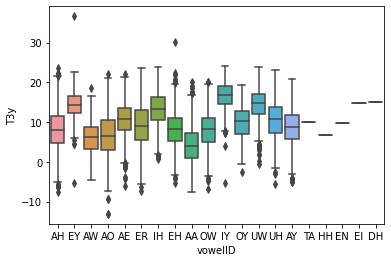

In [10]:
sns.boxplot(x='vowelID',y='T3y',data=summarydf)

<AxesSubplot:xlabel='vowelID', ylabel='T3x'>

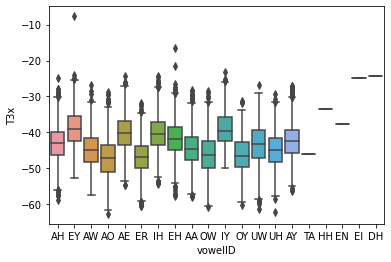

In [11]:
sns.boxplot(x='vowelID',y='T3x',data=summarydf)

We can create a new function that will give us the area inside any polygon.
- input: an unordered list of ordered (x,y) coordinates)
- output: the area of the polygon

In [12]:
def PolygonArea(corners):
    n = len(corners)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

Add word frequency information now.

In [31]:
freqdf = pd.read_table('./SUBTLEXus74286wordstextversion.txt')
freqdf.head(10)

,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,the,1501908,8388,1339811,8388,29449.18,6.1766,100.00,3.9237
1,to,1156570,8383,1138435,8380,22677.84,6.0632,99.94,3.9235
2,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
3,you,2134713,8381,1595028,8376,41857.12,6.3293,99.92,3.9233
4,and,682780,8379,515365,8374,13387.84,5.8343,99.89,3.9232
5,it,963712,8377,685089,8370,18896.31,5.9839,99.87,3.9231
6,s,1057301,8377,1052788,8373,20731.39,6.0242,99.87,3.9231
7,of,590439,8375,573021,8372,11577.24,5.7712,99.85,3.9230
8,for,351650,8374,332686,8370,6895.10,5.5461,99.83,3.9230
9,I,2038529,8372,5147,350,39971.16,6.3093,99.81,3.9229


We need to join the frequency and l dataframes, but we have one more problem to handle -- the words from the XRMB database are in all capital letters while the ones in SUBTLEX are primarily lowercase but with proper names and acronyms capitalized.
We can handle this by creating a new column in _both_ dataframes called 'wordlc' which is equivalent to the 'word' columns, but only lowercase letters.

In [32]:
freqdf['wordlc']=freqdf.Word.apply(lambda x: x.lower() if type(x)==str else x)
summarydf['wordlc']=summarydf.word.apply(lambda x: x.lower())
summarydf.head()

,subject,word,vowelID,stress,t1,t2,center,wordonset,wordend,vowel,...,T2y,T3x,T3y,T4x,T4y,MIx,MIy,MMx,MMy,wordlc
1,JW11,A,EY,1,5.180587,5.251914,5.216250,1.0,1.000,1.0,...,8.787333,-42.886667,11.850333,-55.304667,16.506333,-2.236333,-7.406000,-44.601667,-2.133667,a
3,JW11,ABOUT,AW,1,3.635133,3.814533,3.724833,0.0,0.125,1.0,...,-0.977571,-45.722625,7.102375,-58.395375,13.610750,-1.787625,-11.136625,-43.680625,-4.927125,about
5,JW11,ABOVE,AH,1,6.301556,6.579370,6.440463,0.0,0.000,1.0,...,1.137000,-43.739000,8.924000,-56.249000,14.996000,-1.320000,-10.080000,-42.857000,-4.671000,above
7,JW11,ACROSS,AO,1,5.195691,5.314213,5.254952,0.0,0.000,1.0,...,1.632900,-44.549273,8.916000,-56.292300,15.872800,-1.374455,-10.278091,-43.869909,-3.954545,across
8,JW11,ACTION,AE,1,3.364853,3.579731,3.472292,1.0,0.000,1.0,...,1.183000,-39.770000,10.374000,-53.932000,12.644000,-3.072000,-12.555000,-45.286000,-4.849000,action


Now we can merge the dataframes on the newly created column.

In [33]:
summarydf = summarydf.merge(freqdf,left_on='wordlc',right_on='wordlc')
summarydf.head()

,subject,word,vowelID,stress,t1,t2,center,wordonset,wordend,vowel,...,wordlc,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,JW11,A,EY,1,5.180587,5.251914,5.216250,1.0,1.0,1.0,...,a,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
1,JW12,A,EY,1,8.892942,9.023068,8.958005,1.0,1.0,1.0,...,a,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
2,JW13,A,EY,1,9.277589,9.380663,9.329126,1.0,1.0,1.0,...,a,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
3,JW14,A,EY,1,7.285286,7.380274,7.332780,1.0,1.0,1.0,...,a,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
4,JW15,A,AY,1,24.441016,24.582376,24.511696,1.0,0.0,1.0,...,a,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234


In [35]:
summarydf['freqcat']=np.floor(summarydf.Lg10WF)
summarysummarydf = summarydf.groupby(['subject','vowelID','freqcat']).mean().reset_index()
summarysummarydf = summarysummarydf[['subject','vowelID','freqcat','ULx','ULy','T3x','T3y']]
summarysummarydf = summarysummarydf[summarysummarydf.vowelID.isin(['IY','UW','AA','AE'])]
summarysummarydf.head()

,subject,vowelID,freqcat,ULx,ULy,T3x,T3y
0,JW11,AA,1.0,14.030250,17.936278,-43.490278,6.523500
1,JW11,AA,2.0,14.470000,18.050667,-41.789667,10.913000
2,JW11,AA,3.0,14.377828,17.460382,-44.780783,9.297861
3,JW11,AA,4.0,13.682367,17.505367,-43.989515,4.490394
4,JW11,AA,5.0,14.874159,18.246937,-42.404032,12.239365


In [36]:
byfreqdf = summarysummarydf.pivot(index=['subject','freqcat'], columns=['vowelID'], values=['T3x','T3y'])

In [37]:
byfreqdf['area']=byfreqdf.apply(lambda x: PolygonArea([(x.T3x.AA,x.T3y.AA),(x.T3x.IY,x.T3y.IY),
                                      (x.T3x.UW,x.T3y.UW),(x.T3x.AE,x.T3y.AE)]),axis=1)
byfreqdf

T3x                                         T3y  \
vowelID                 AA         AE         IY         UW         AA   
subject freqcat                                                          
JW11    1.0     -43.490278 -36.920500 -33.357500 -37.347500   6.523500   
        2.0     -41.789667 -37.935967 -32.426264 -36.049667  10.913000   
        3.0     -44.780783 -37.091987 -31.937679 -36.578900   9.297861   
        4.0     -43.989515 -35.296762 -31.265030 -36.645590   4.490394   
        5.0     -42.404032 -37.199952 -33.060603 -34.993688  12.239365   
...                    ...        ...        ...        ...        ...   
JW63    2.0     -34.961000 -31.986533 -28.371629 -30.529167   6.272250   
        3.0     -36.679666 -30.001608 -28.612531 -32.696300   5.717136   
        4.0     -35.400795 -29.109204 -28.239638 -31.830579   4.457682   
        5.0     -35.572073 -30.368563 -28.368609 -33.513571   7.055635   
        6.0            NaN        NaN        NaN -31.576727        NaN   

                                                       area  
vowelID                 AE         IY         UW             
subject freqcat                                              
JW11    1.0       8.415000  17.770500  19.435500   5.731651  
        2.0      13.883750  22.189336  18.014000   4.274834  
        3.0      12.908079  21.150793  19.441314   7.661644  
        4.0      11.568487  21.244054  19.055881   6.166241  
        5.0      12.916137  21.065305  16.386000  21.611884  
...                    ...        ...        ...        ...  
JW63    2.0      12.434833  19.592687  16.054167   1.819140  
        3.0      11.741200  18.968583  17.421057   6.265835  
        4.0      13.498344  19.393553  16.567092   5.258622  
        5.0       8.989363  18.977281  15.689286   1.646621  
        6.0            NaN        NaN  16.544927        NaN  

[289 rows x 9 columns]

<AxesSubplot:xlabel='freqcat', ylabel='area'>

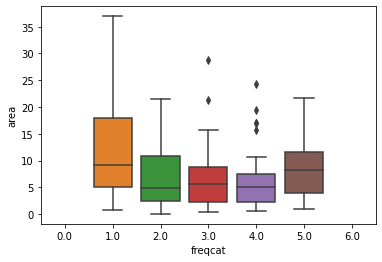

In [38]:
sns.boxplot(x='freqcat', y='area', data=byfreqdf.reset_index())

What do we see? Do we think there is much of a relationship between word frequency (higher numbers refer to more frequent words) and vowel polygon area (higher numbers means larger area and more peripherality)?

We don't see what we're expecting after frequency category 4, what could be happening?
- word / vowel length?

<AxesSubplot:xlabel='Lg10WF', ylabel='T3x'>

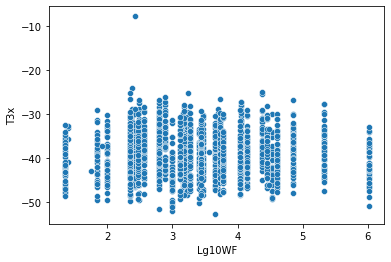

In [27]:
sns.scatterplot(x='Lg10WF', y='T3x', data=summarydf[summarydf.vowelID=='EY'])